In [1]:
# Import libraries and add constants
import json
import os
from pathlib import Path

import glob
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
sns.set_style('ticks')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.gcf().clear()
# scale_ = 0.45
# new_size = (scale_ * 10, scale_ * 8.5)
# plt.gcf().set_size_inches(new_size)

models = ["kmeans-minibatch", "dbscan", "hac", "hdbscan", "birch"]
norm_models = ["dbscan", "hdbscan"]
output_dir = "../output/nlp"
os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin/'
figs_path = Path('nlp')
figs_path.mkdir(parents=True, exist_ok=True)

In [2]:
num_random_trials = 50
num_bayesian_trials = 50
num_reinits = 5

In [3]:

from itertools import product

csv_files = [ x for x in os.listdir(output_dir) if x.endswith(".csv")]
datasets = sorted(list(set([ "_".join(os.path.splitext(output_dir + "/" + x)[0].split("_")[3:-1]) for x in csv_files])))
df_list = {'random': [], 'bayesian': []}
df_list_normalized = { 'random': [], 'bayesian': []}
for file in csv_files:
    f_splits = file.split("_")
    model = f_splits[1]
    normalize=False
    is_bayesian_trial = False
    last_word = file.split("_")[-1].split(".")[0]
    if last_word == "bayesian":
        is_bayesian_trial = True        
        dataset = "_".join(f_splits[2:-2])
        reinit_index = f_splits[-2]
    else:
        dataset = "_".join(f_splits[2:-1])
        reinit_index = last_word
    
    if dataset.split("_")[-1] == "normalized" or model in norm_models:
        if model in norm_models:
            dataset = dataset + "_normalized"
        normalize = True
    
    df = pd.read_csv(output_dir + "/" + file)
    df['model'] = [model] * df.shape[0]
    df['dataset'] = [dataset] * df.shape[0]
    df['reinit_index'] = [reinit_index] * df.shape[0]
    df = df.filter(items=['model', 'dataset', 'adjusted_rand_score', 'reinit_index', 'trial_index', 'generator_model'])
    if is_bayesian_trial:
        df = df[df['generator_model'] == 'BO']
    else:
        df = df[df['generator_model'] == 'Sobol']
    
    trial_type = 'bayesian' if is_bayesian_trial else 'random'
    if normalize:
        df_list_normalized[trial_type].append(df)
    else:
        df_list[trial_type].append(df)
all_df = {'random': [], 'bayesian': []}
all_df_normalized = {'random': [], 'bayesian': []}
for trial_type in ['random', 'bayesian']:
    all_df[trial_type] = pd.concat(df_list[trial_type])
    avg_perf_by_model = all_df[trial_type].groupby(['model', 'dataset']).agg(max_within_dataset=('adjusted_rand_score', 'max')).groupby('model').agg(avg_perf=('max_within_dataset', 'mean'))
    avg_perf_by_model = avg_perf_by_model.sort_values(['avg_perf'], ascending=False)
    print(trial_type, "trials max average performance by model when dataset is not normalized")
    print(avg_perf_by_model)
    print()

    all_df_normalized[trial_type] = pd.concat(df_list_normalized[trial_type])
    avg_perf_by_model_normalized = all_df_normalized[trial_type].groupby(['model', 'dataset']).agg(max_within_dataset=('adjusted_rand_score', 'max')).groupby('model').agg(avg_perf=('max_within_dataset', 'mean'))
    avg_perf_by_model_normalized = avg_perf_by_model_normalized.sort_values(['avg_perf'], ascending=False)
    print(trial_type, "trials max average performance by model when dataset is normalized")
    print(avg_perf_by_model_normalized)
    print()

random trials max average performance by model when dataset is not normalized
                  avg_perf
model                     
kmeans-minibatch  0.484409
hac               0.394668
birch             0.218510

random trials max average performance by model when dataset is normalized
                  avg_perf
model                     
kmeans-minibatch  0.503234
hac               0.440608
birch             0.275597
dbscan            0.198685
hdbscan           0.095127

bayesian trials max average performance by model when dataset is not normalized
                  avg_perf
model                     
kmeans-minibatch  0.504500
hac               0.394668
birch             0.225636

bayesian trials max average performance by model when dataset is normalized
                  avg_perf
model                     
kmeans-minibatch  0.530934
hac               0.440608
birch             0.279329
dbscan            0.216705
hdbscan           0.098706



In [4]:
def get_random_metric(random_df, K_rand, T):
    mx_list = []
    for i in range(T):
        mx_list.append(random_df[['model', 'adjusted_rand_score']].sample(n=K_rand, random_state=i, replace=False).groupby('model').agg(rand_performance=('adjusted_rand_score', 'max')))
    x = pd.concat(mx_list)
    x['K'] = [K] * len(x)
    return x

<Figure size 640x480 with 0 Axes>

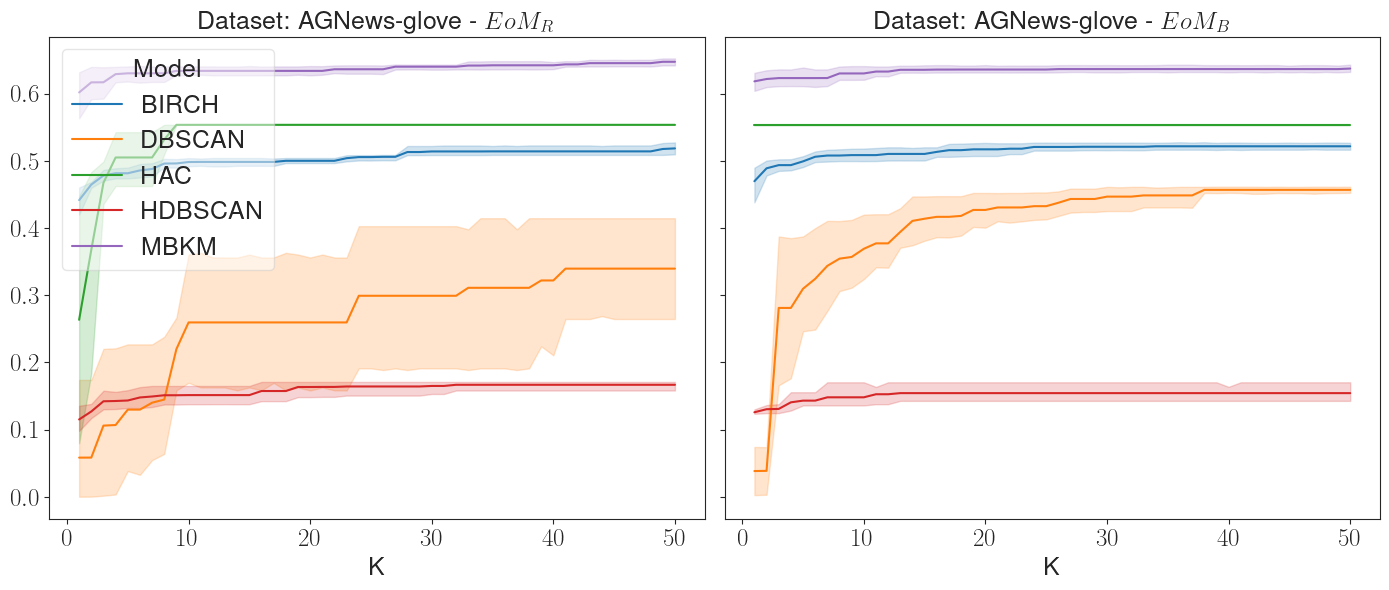

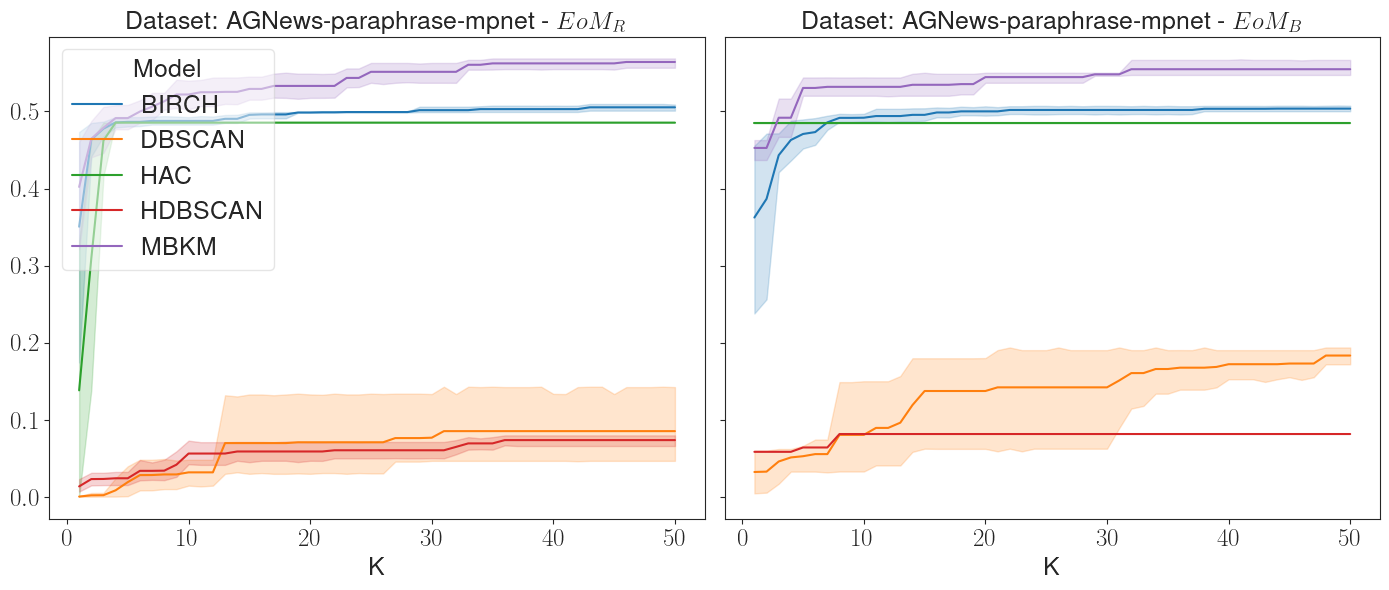

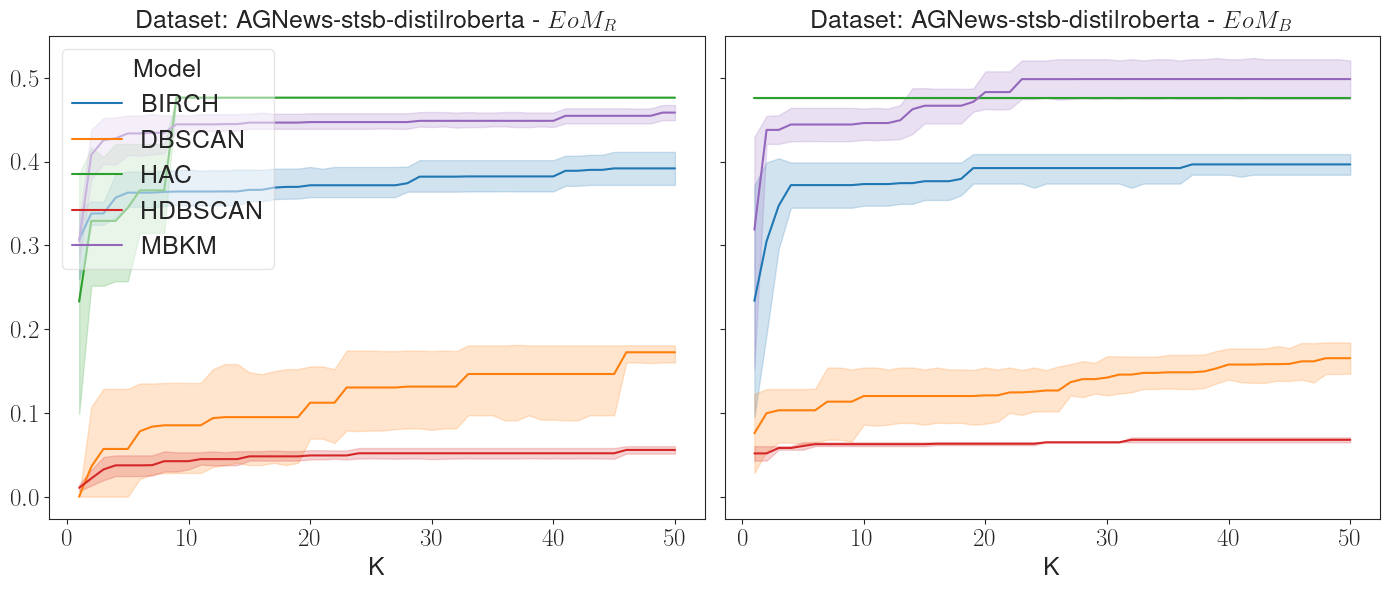

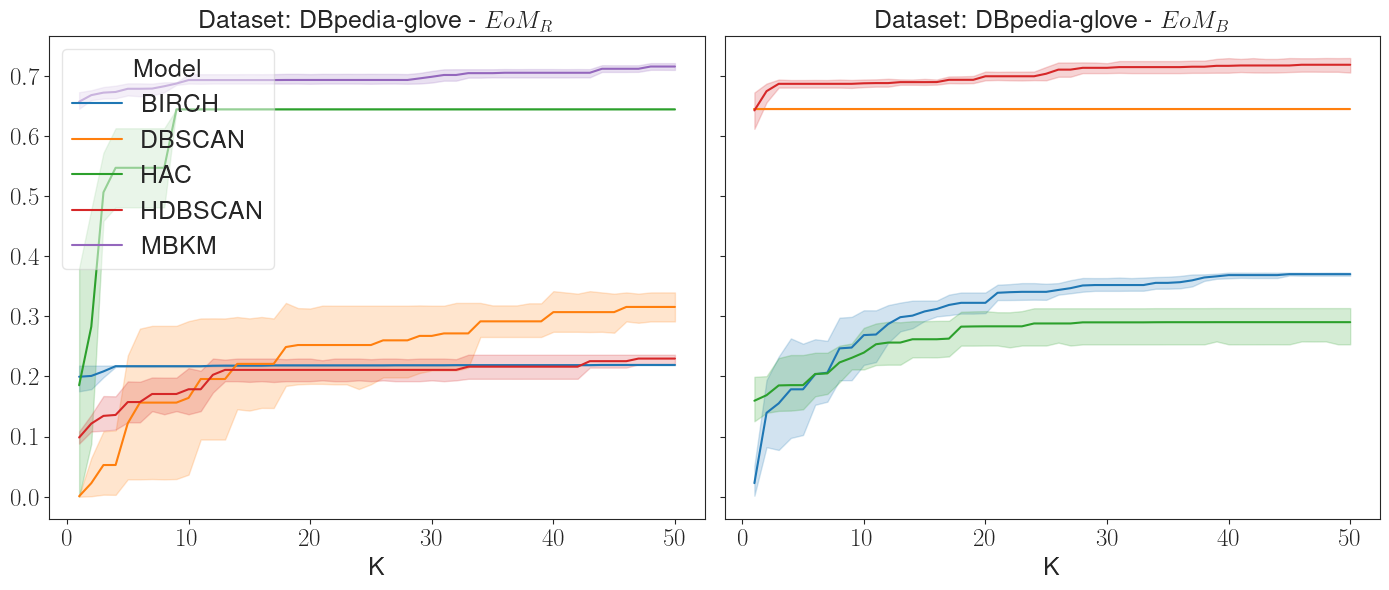

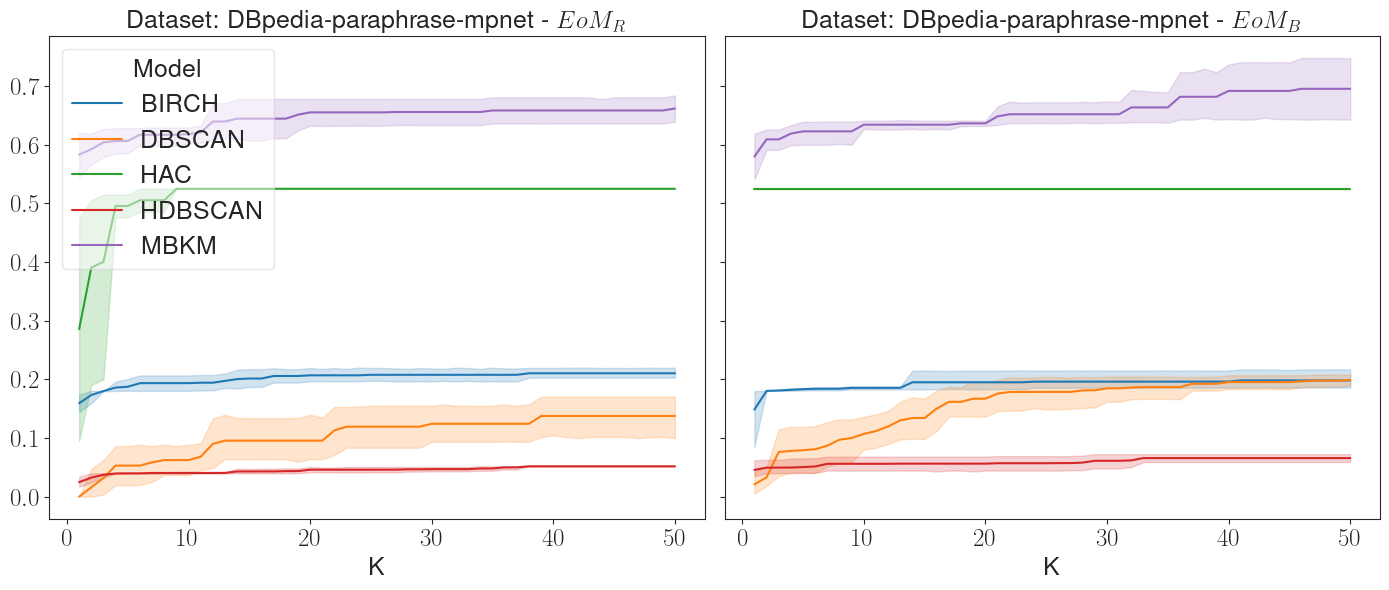

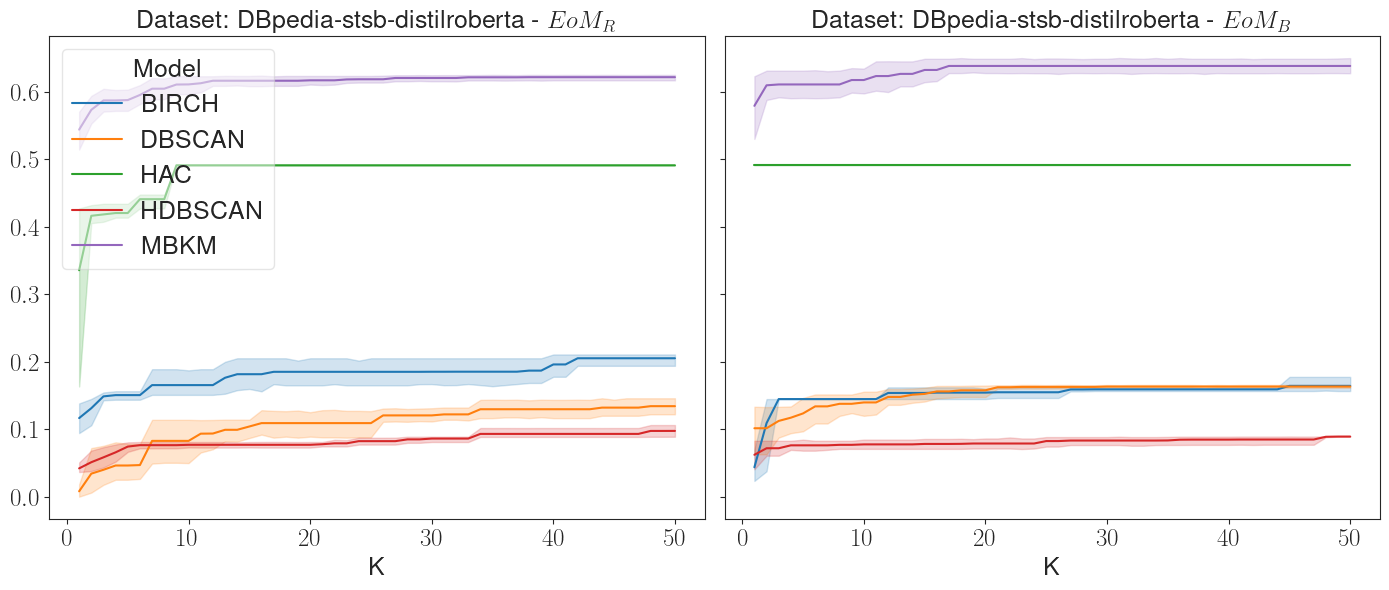

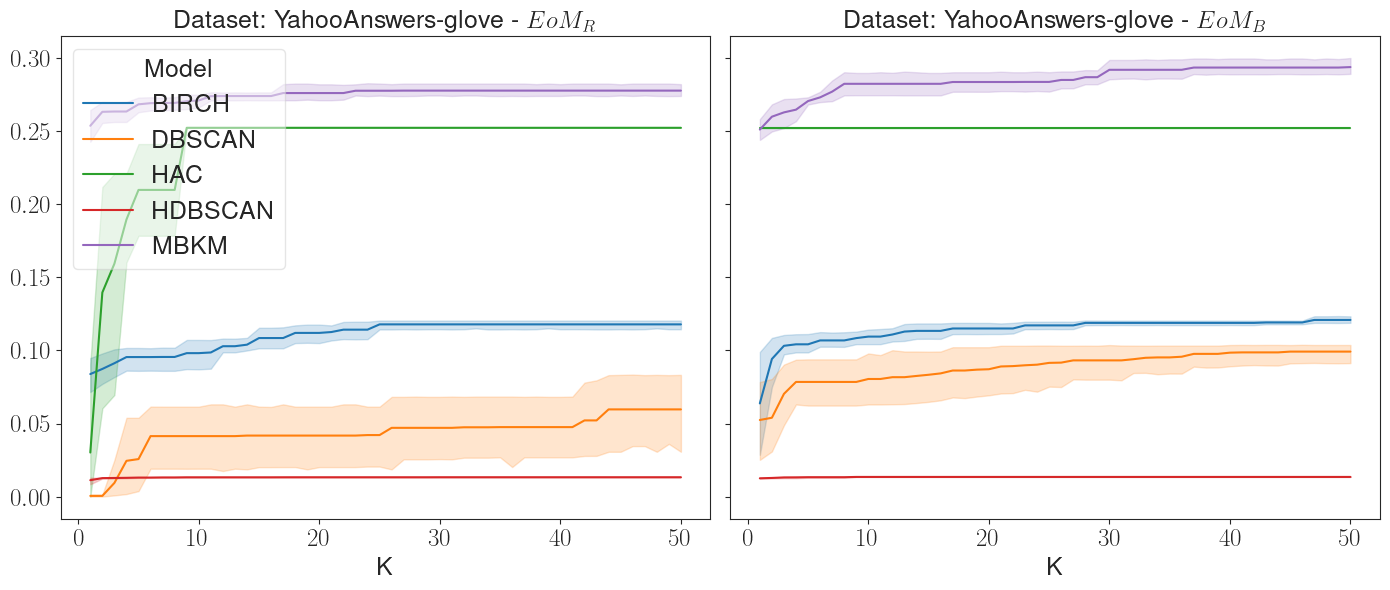

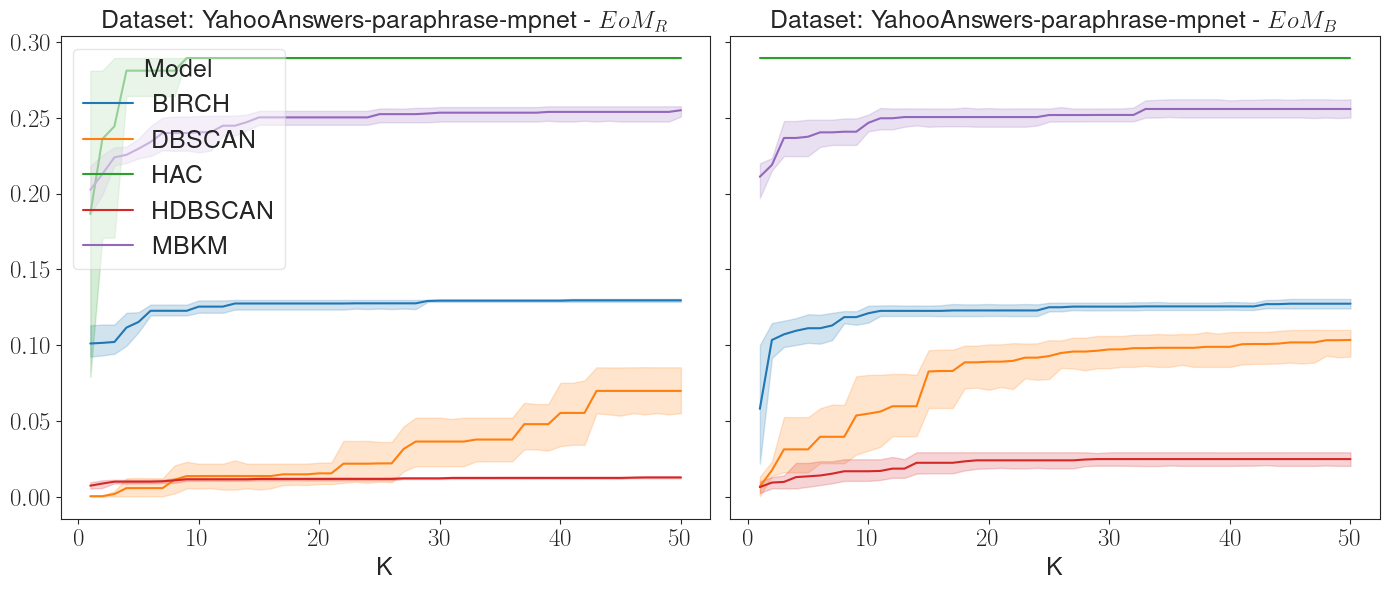

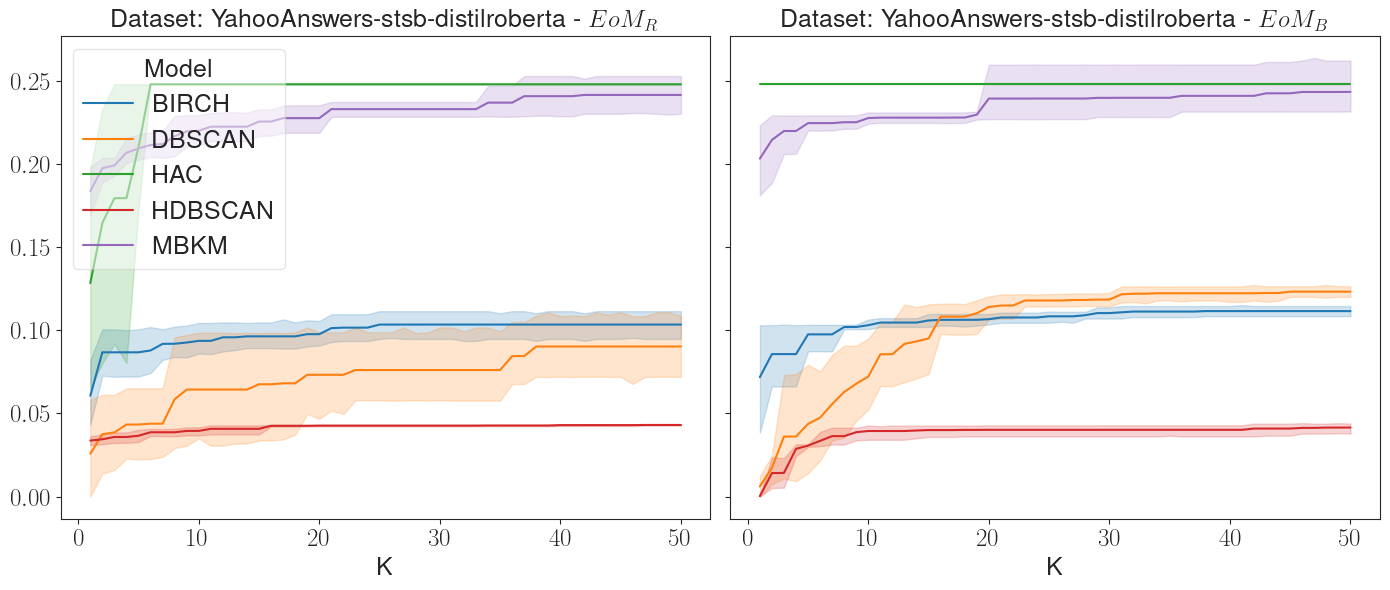

In [5]:
# Generate violin plot and ease of tuning metric
random_metric_dfs = []
bayesian_metric_dfs = []

groups_random = all_df['random'].groupby(['dataset'])
groups_normalized_random = all_df_normalized['random'].groupby(['dataset'])

groups_bayesian = all_df['bayesian'].groupby(['dataset'])
groups_normalized_bayesian = all_df_normalized['bayesian'].groupby(['dataset'])
for dataset in datasets:
    if len(dataset.split("_")) > 1:
        continue
        
    try:
        group_data_normalized_random = groups_normalized_random.get_group(dataset + "_normalized")[['model', 'adjusted_rand_score', 'trial_index', 'reinit_index']].reset_index(drop=True)
        group_data_normalized_bayesian = groups_normalized_bayesian.get_group(dataset + "_normalized")[['model', 'adjusted_rand_score', 'trial_index', 'reinit_index']].reset_index(drop=True)
    except KeyError as e:
        continue
    random_metrics_df_normalized = []
    bayesian_metrics_df_normalized = []
    # display("grp rand", group_data_normalized_random)
    try:
        random_df_normalized = group_data_normalized_random.groupby(['model'])
        for K in range(1, num_random_trials + 1):
            random_metrics_df_normalized.append(get_random_metric(random_df_normalized, K, num_reinits))
        random_metrics_df_normalized = pd.concat(random_metrics_df_normalized)
        #display("rand", random_metrics_df_normalized)
        # display("gdata norm", group_data_normalized_bayesian)
        
        bayesian_df_normalized = group_data_normalized_bayesian.sort_values(['model', 'reinit_index', 'trial_index'])
        # display("sorted1", bayesian_df_normalized)
        bayesian_df_normalized['bayes_performance'] = bayesian_df_normalized.groupby(['model', 'reinit_index'])['adjusted_rand_score'].cummax()
        bayesian_df_normalized = bayesian_df_normalized[['model', 'trial_index', 'reinit_index', 'bayes_performance']].reset_index(drop=True)
        bayesian_metrics_df_normalized = bayesian_df_normalized
    except Exception:
        continue

    random_metrics_df_normalized = random_metrics_df_normalized.rename(columns={"rand_performance": "perf"}).reset_index()
    bayesian_metrics_df_normalized = bayesian_metrics_df_normalized.rename(columns={"bayes_performance": "perf", "trial_index": "K"}).reset_index(drop=True)
    random_metrics_df_normalized.loc[random_metrics_df_normalized['model'] == 'kmeans-minibatch', 'model'] = 'mbkm'
    random_metrics_df_normalized['model'] = random_metrics_df_normalized['model'].str.upper()
    #display(random_metrics_df_normalized[random_metrics_df_normalized['model'] == 'HAC'])
    best_hac = random_metrics_df_normalized[random_metrics_df_normalized['model'] == 'HAC']['perf'].max()
    #print("bh", best_hac)
    random_metrics_df_normalized.loc[((random_metrics_df_normalized['model'] == 'HAC')  & (random_metrics_df_normalized['K'] > 8)), 'perf'] = best_hac
    random_metrics_df_normalized_agg = random_metrics_df_normalized.groupby(['K', 'model']).mean().reset_index()
    # display("rand agg", random_metrics_df_normalized_agg)
    random_metric_dfs.append(random_metrics_df_normalized_agg)
    
    bayesian_metrics_df_normalized.loc[bayesian_metrics_df_normalized['model'] == 'kmeans-minibatch', 'model'] = 'mbkm'
    bayesian_metrics_df_normalized['model'] = bayesian_metrics_df_normalized['model'].str.upper()
    bayesian_metrics_df_normalized.loc[bayesian_metrics_df_normalized['model'] == 'HAC', 'perf'] = best_hac
    bayesian_metrics_df_normalized['K'] = bayesian_metrics_df_normalized['K'] - 9
    bayesian_metrics_df_normalized_agg = bayesian_metrics_df_normalized.groupby(['model', 'K']).mean().reset_index()
    # display("norm", bayesian_metrics_df_normalized)
    # display("agg", bayesian_metrics_df_normalized_agg)
    bayesian_metric_dfs.append(bayesian_metrics_df_normalized_agg)

    # print("Dataset", dataset, "mx_rand", mx_random_metric_map[dataset], "mx_bayes", mx_bayesian_metric_map[dataset])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    g1 = sns.lineplot(ax=ax1, x="K", y="perf", hue="model", data=random_metrics_df_normalized)
    ax1.set_title('Dataset: ' + dataset + " - $EoM_{R}$", fontsize=18)
    ax1.set_ylabel("")
    l1 = ax1.legend(loc='upper left', title='Model', fontsize=18, fancybox=True, framealpha=0.5)
    l1.get_title().set_fontsize(18)

    
    g2 = sns.lineplot(ax=ax2, x="K", y="perf", hue="model", data=bayesian_metrics_df_normalized)
    ax2.set_title('Dataset: ' + dataset + " - $EoM_{B}$", fontsize=18)
    ax1.set_ylabel("")
    ax2.get_legend().remove()
    plt.tight_layout()
    
    plt.show()
    fig.savefig("nlp/" + dataset + ".pdf", bbox_inches='tight')


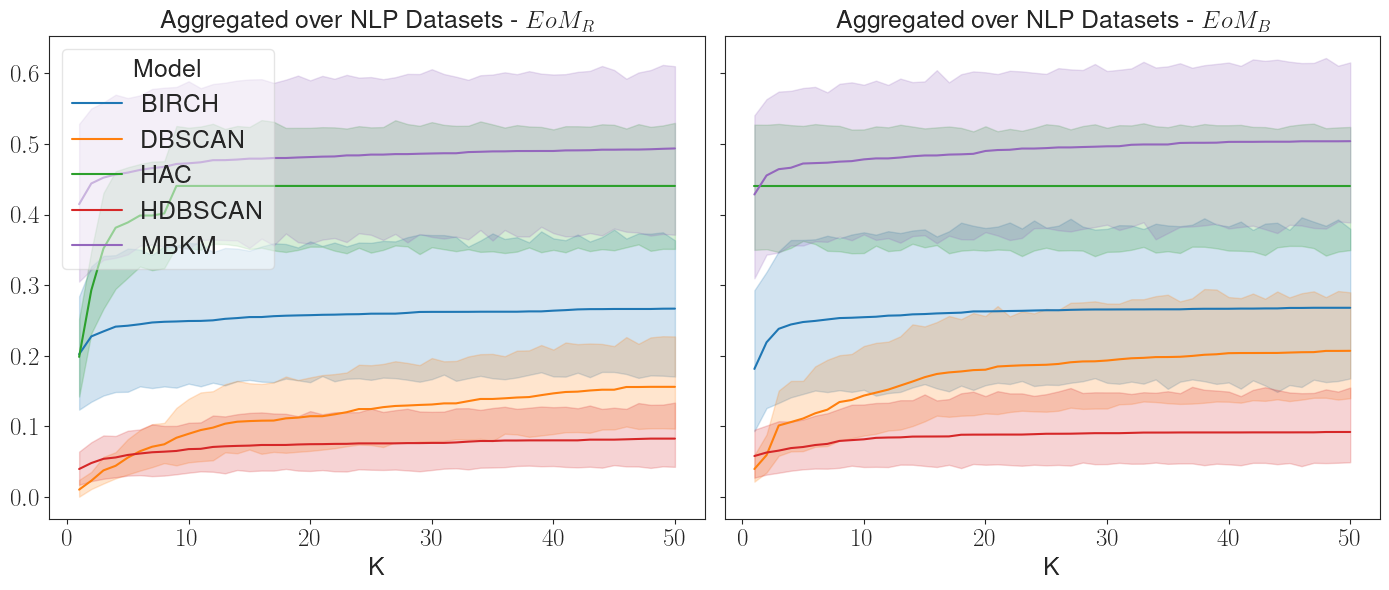

In [6]:
# Aggregate metric analysis
random_metric_agg_df = pd.concat(random_metric_dfs)
bayesian_metric_agg_df = pd.concat(bayesian_metric_dfs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
g1 = sns.lineplot(ax=ax1, x="K", y="perf", hue="model", data=random_metric_agg_df)
ax1.set_title('Aggregated over NLP Datasets - $EoM_{R}$', fontsize=18)
ax1.set_ylabel("")
l1 = ax1.legend(loc='upper left', title='Model', fontsize=18, fancybox=True, framealpha=0.5)
l1.get_title().set_fontsize(18)


g2 = sns.lineplot(ax=ax2, x="K", y="perf", hue="model", data=bayesian_metric_agg_df)
ax2.set_title('Aggregated over NLP Datasets - $EoM_{B}$', fontsize=18)
ax1.set_ylabel("")
ax2.get_legend().remove()
plt.tight_layout()

plt.show()
fig.savefig("nlp-aggregated.pdf", bbox_inches='tight')